In [1]:
%matplotlib inline

In [2]:
import jax
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import jax.numpy as jnp

from flax import linen as nn
from flax.training import train_state

from tqdm import trange
import optax

# Potential and equilibrium points

In [3]:
def U(xs, beta=1.0):
    x, y = xs[:, 0], xs[:, 1]
    e1 = -200 * jnp.exp(-(x - 1) ** 2 - 10 * y ** 2)
    e2 = -100 * jnp.exp(-x ** 2 - 10 * (y - 0.5) ** 2)
    e3 = -170 * jnp.exp(-6.5 * (0.5 + x) ** 2 + 11 * (x + 0.5) * (y - 1.5) - 6.5 * (y - 1.5) ** 2)
    e4 = 15.0 * jnp.exp(0.7 * (1 + x) ** 2 + 0.6 * (x + 1) * (y - 1) + 0.7 * (y - 1) ** 2)
    return beta * (e1 + e2 + e3 + e4)


dUdx_fn = jax.grad(lambda _x: U(_x).sum())

## Choose first or second order

In [4]:
first_order = True

if first_order:
    A = jnp.array([[-0.55828035, 1.44169]])
    B = jnp.array([[0.62361133, 0.02804632]])
    ndim = A.shape[1]
    T = 0.05
    gamma = 1.0
    m = jnp.array([[1.0, 1.0]])
    xi = jnp.array([[3.0, 3.0]])


    def drift(_x):
        return -dUdx_fn(_x) / (gamma * m)
else:
    A = jnp.array([[-0.55828035, 1.44169, 0.0, 0.0]])
    B = jnp.array([[0.62361133, 0.02804632, 0.0, 0.0]])
    ndim = A.shape[1]
    T = 100.0
    k, Temp, gamma = 1.0, 1.0, 1.0
    m = jnp.array([[1.0, 2.0]])
    xi = jnp.sqrt(2 * k * Temp / (m * gamma))  # notation of Dellago eq. 19
    xi = jnp.hstack([jnp.array([[1e-3, 1e-3]]), xi * jnp.ones((1, 2))])


    def drift(_x):
        return jnp.hstack([_x[:, 2:], -gamma * _x[:, 2:] - dUdx_fn(_x[:, :2]) / m])

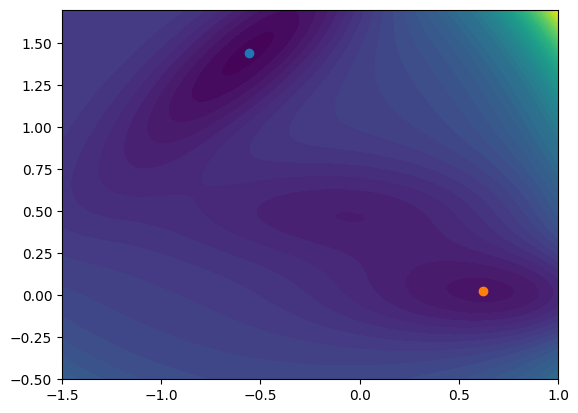

In [5]:
x, y = np.linspace(-1.5, 1.0, 100), np.linspace(-0.5, 1.7, 100)
x, y = np.meshgrid(x, y)
z = U(np.stack([x, y], -1).reshape(-1, 2)).reshape([100, 100])
plt.contourf(x, y, z, 50)
plt.scatter(A[0, 0], A[0, 1])
plt.scatter(B[0, 0], B[0, 1])

# MLPs and the loss function
You can choose from: 
1. full covariance matrix parameterization
2. diagonal covariance matrix parameterization (used for the results in the paper)
3. paramaterization via interpolants (without neural networks)

In [6]:
from models import MLPfull, MLPdiag, Interpolant

In [7]:
q = MLPfull(T, A, B, ndim)

BS = 512
key = jax.random.PRNGKey(1)
key, *init_key = jax.random.split(key, 3)
params_q = q.init(init_key[0], jnp.ones([BS, 1]))

optimizer_q = optax.adam(learning_rate=1e-4)
state_q = train_state.TrainState.create(apply_fn=q.apply,
                                        params=params_q,
                                        tx=optimizer_q)

In [8]:
def v_t_diag(_eps, _t, _params_q):
    gauss_params = lambda _t: state_q.apply_fn(_params_q, _t)

    def dgauss_paramsdt(_t):
        _gauss_params = lambda _t: jax.tree_util.tree_map(lambda _a: _a.sum(0), gauss_params(_t))
        return jax.tree_util.tree_map(lambda a: a.squeeze().T, jax.jacrev(_gauss_params)(_t))

    _eps = _eps.squeeze()
    mu_t_val, s_val = gauss_params(_t)
    dmudt_val, dsdt_val = dgauss_paramsdt(_t)
    _x = mu_t_val + s_val * _eps
    dlogdx = -_eps / s_val
    u_t = dmudt_val - 0.5 * (2 * dsdt_val * s_val) * dlogdx
    return u_t + 0.5 * (xi ** 2) * dlogdx.squeeze() - drift(_x)


def v_t_full(_eps, _t, _params_q):
    gauss_params = lambda __t: state_q.apply_fn(_params_q, __t)

    def dgauss_paramsdt(__t):
        _gauss_params = lambda __t: jax.tree_util.tree_map(lambda __a: __a.sum(0), gauss_params(__t))
        return jax.tree_util.tree_map(lambda __a: __a.squeeze().T, jax.jacrev(_gauss_params)(__t))

    mu_t_val, S_t_val = gauss_params(_t)
    dmudt_val, dSdt_val = dgauss_paramsdt(_t)
    _x = mu_t_val + jax.lax.batch_matmul(S_t_val, _eps).squeeze()
    dlogdx = -jax.scipy.linalg.solve_triangular(jnp.transpose(S_t_val, (0, 2, 1)), _eps)
    dSigmadt = jax.lax.batch_matmul(dSdt_val, jnp.transpose(S_t_val, (0, 2, 1)))
    dSigmadt += jax.lax.batch_matmul(S_t_val, jnp.transpose(dSdt_val, (0, 2, 1)))
    u_t = dmudt_val - 0.5 * jax.lax.batch_matmul(dSigmadt, dlogdx).squeeze()
    return u_t + 0.5 * (xi ** 2) * dlogdx.squeeze() - drift(_x)


v_t = v_t_diag if type(q) == MLPdiag else v_t_full


def loss_fn(params_q, key):
    key = jax.random.split(key)
    t = T * jax.random.uniform(key[0], [BS, 1])
    eps = jax.random.normal(key[1], [BS, ndim, 1])
    loss = 0.5 * ((v_t(eps, t, params_q) / xi) ** 2).sum(1, keepdims=True)
    print(loss.shape, 'loss.shape', flush=True)
    return loss.mean()


@jax.jit
def train_step(state_q, key):
    grad_fn = jax.value_and_grad(loss_fn, argnums=0)
    loss, grads = grad_fn(state_q.params, key)
    state_q = state_q.apply_gradients(grads=grads)
    return state_q, loss


key, loc_key = jax.random.split(key)
state_q, loss = train_step(state_q, loc_key)

(512, 1) loss.shape


# Training loop

In [9]:
loss_plot = []
states = []
for i in trange(2000 if ndim < 4 else 20000):
    key, loc_key = jax.random.split(key)
    state_q, loss = train_step(state_q, loc_key)
    if i % 10 == 0:
        states.append(jax.tree.map(jnp.copy, state_q))
    loss_plot.append(loss)

100%|██████████| 2000/2000 [00:02<00:00, 802.04it/s]


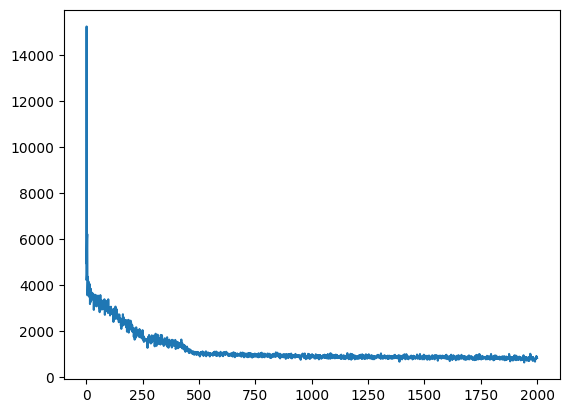

In [10]:
plt.figure(figsize=(6.4, 4.8))
plt.plot(loss_plot)
# plt.yscale('log')

# Samples from $q_t$

In [13]:
t = T * jnp.linspace(0, 1, BS).reshape((-1, 1))
key, path_key = jax.random.split(key)
eps = jax.random.normal(path_key, [BS, ndim, 1])

for i in range(len(states)):
    fig, axs = plt.subplots(1,2,figsize=(15, 6))
    axs[0].contourf(x, y, z, 50)
    mu_t, S_t = state_q.apply_fn(states[i].params, t)
    if type(q) == MLPdiag:  # diag parameterization
        samples = mu_t + S_t * eps.squeeze()
    else:  # full covariance parameterization
        samples = mu_t + jax.lax.batch_matmul(S_t, eps).squeeze()
    axs[0].scatter(samples[:, 0], samples[:, 1])
    axs[0].scatter(A[0, 0], A[0, 1], color='red')
    axs[0].scatter(B[0, 0], B[0, 1], color='orange')
    axs[0].set_xlim(x.min(),x.max())
    axs[0].set_ylim(y.min(),y.max())
    axs[0].set_xticks([], [])
    axs[0].set_yticks([], [])

    # ax = plt.subplot(122)
    axs[1].contourf(x, y, z, 50)
    axs[1].plot(mu_t[:,0], mu_t[:,1])
    for j in range(32):
      axs[1].add_patch(matplotlib.patches.Ellipse((mu_t[::16,0][j], mu_t[::16,1][j]), 
                                              width=jnp.sqrt(S_t[::16,0,0][j]), height=jnp.sqrt(S_t[::16,1,1][j]), alpha=0.2))
    axs[1].scatter(A[0, 0], A[0, 1], color='red')
    axs[1].scatter(B[0, 0], B[0, 1], color='orange')
    axs[1].set_xlim(x.min(),x.max())
    axs[1].set_ylim(y.min(),y.max())
    axs[1].set_xticks([], [])
    axs[1].set_yticks([], [])
    fig.tight_layout()
    fig.savefig(f'./gifs/training/{i:03d}.png', bbox_inches='tight')
    fig.clf()
    plt.close()

# Sampling paths via the learned vector field
## Deterministically

This corresponds to the continuity equation for the Gaussian parameterization
$$u_t^o(x) = \frac{\partial \mu_t}{\partial t} + \frac{1}{2}\frac{\partial \Sigma_t}{\partial t}\Sigma_t^{-1}(x-\mu_t)$$

In [14]:
gauss_params = lambda _t: state_q.apply_fn(state_q.params, _t)


def dgauss_paramsdt(_t):
    _gauss_params = lambda _t: jax.tree_util.tree_map(lambda _a: _a.sum(0), gauss_params(_t))
    return jax.tree_util.tree_map(lambda a: a.squeeze().T, jax.jacrev(_gauss_params)(_t))


@jax.jit
def u_t_full(_t, _x):
    mu_t_val, S_t_val = gauss_params(_t)
    dmudt_val, dSdt_val = dgauss_paramsdt(_t)
    dSigmadt = jax.lax.batch_matmul(dSdt_val, jnp.transpose(S_t_val, (0, 2, 1)))
    dSigmadt += jax.lax.batch_matmul(S_t_val, jnp.transpose(dSdt_val, (0, 2, 1)))
    STdlogdx = jax.scipy.linalg.solve_triangular(S_t_val, (_x - mu_t_val)[..., None])
    dlogdx = -jax.scipy.linalg.solve_triangular(jnp.transpose(S_t_val, (0, 2, 1)), STdlogdx)
    u_t = dmudt_val - 0.5 * jax.lax.batch_matmul(dSigmadt, dlogdx).squeeze()
    return u_t


@jax.jit
def u_t_diag(_t, _x):
    mu_t_val, s_val = gauss_params(_t)
    dmudt_val, dsdt_val = dgauss_paramsdt(_t)
    dlogdx = -(_x - mu_t_val) / s_val ** 2
    u_t = dmudt_val - 0.5 * dlogdx * (2 * dsdt_val * s_val)
    return u_t


u_t = u_t_diag if type(q) == MLPdiag else u_t_full

In [15]:
N = int(1e3) if ndim < 4 else int(1e4)
dt = T / N
key, loc_key = jax.random.split(key)
x_t = jnp.ones((BS, N + 1, ndim)) * A
t = jnp.zeros((BS, 1))
eps = jax.random.normal(key, shape=(BS, ndim, 1))
_, S_t = gauss_params(t)
if type(q) == MLPdiag:
    x_t = x_t.at[:, 0, :].set(x_t[:, 0, :] + S_t * eps.squeeze())
else:
    x_t = x_t.at[:, 0, :].set(x_t[:, 0, :] + jax.lax.batch_matmul(S_t, eps).squeeze())
for i in trange(N):
    dxdt = u_t(t, x_t[:, i, :])
    dx = dt * dxdt
    x_t = x_t.at[:, i + 1, :].set(x_t[:, i, :] + dx)
    t += dt

x_t_det = x_t.copy()

100%|██████████| 1000/1000 [00:03<00:00, 303.37it/s]


## Stochastically

This corresponds to the Fokker-Planck equation for the Gaussian parameterization
From the vector field that solves the continuity equation, we can get the vector field that satisfies the Fokker-Planck equation
$$u_t^q(x) = u_t^o(x) + G_t\nabla_x\log q_t(x) = u_t^o(x) - G_t\Sigma_t^{-1}(x-\mu_t),$$

In [16]:
@jax.jit
def u_t_stoch_full(_t, _x):
    mu_t_val, S_t_val = gauss_params(_t)
    dmudt_val, dSdt_val = dgauss_paramsdt(_t)
    if ndim >= 4:
        S_t_val += 1e-1 * jnp.eye(ndim)[None, ...]
    dSigmadt = jax.lax.batch_matmul(dSdt_val, jnp.transpose(S_t_val, (0, 2, 1)))
    dSigmadt += jax.lax.batch_matmul(S_t_val, jnp.transpose(dSdt_val, (0, 2, 1)))
    STdlogdx = jax.scipy.linalg.solve_triangular(S_t_val, (_x - mu_t_val)[..., None])
    dlogdx = -jax.scipy.linalg.solve_triangular(jnp.transpose(S_t_val, (0, 2, 1)), STdlogdx)
    out = dmudt_val + (-0.5 * jax.lax.batch_matmul(dSigmadt, dlogdx) + 0.5 * xi[..., None] ** 2 * dlogdx).squeeze()
    return out


@jax.jit
def u_t_stoch_diag(_t, _x):
    mu_t_val, s_val = gauss_params(_t)
    dmudt_val, dsdt_val = dgauss_paramsdt(_t)
    dlogdx = -(_x - mu_t_val) / s_val ** 2
    u_t = dmudt_val - 0.5 * dlogdx * (2 * dsdt_val * s_val) + 0.5 * xi ** 2 * dlogdx
    return u_t


u_t_stoch = u_t_stoch_diag if type(q) == MLPdiag else u_t_stoch_full

In [17]:
N = int(1e3) if ndim < 4 else int(1e4)
dt = T / N
key, loc_key = jax.random.split(key)
x_t = jnp.ones((BS, N + 1, ndim)) * A
t = jnp.zeros((BS, 1))
eps = jax.random.normal(key, shape=(BS, ndim, 1))
_, S_t = gauss_params(t)
if type(q) == MLPdiag:
    x_t = x_t.at[:, 0, :].set(x_t[:, 0, :] + S_t * eps.squeeze())
else:
    x_t = x_t.at[:, 0, :].set(x_t[:, 0, :] + jax.lax.batch_matmul(S_t, eps).squeeze())
for i in trange(N):
    key, loc_key = jax.random.split(key)
    eps = jax.random.normal(key, shape=(BS, ndim))
    dxdt = u_t_stoch(t, x_t[:, i, :])
    dx = dt * dxdt + jnp.sqrt(dt) * xi * eps
    x_t = x_t.at[:, i + 1, :].set(x_t[:, i, :] + dx)
    t += dt

x_t_stoch = x_t.copy()

100%|██████████| 1000/1000 [00:04<00:00, 241.63it/s]


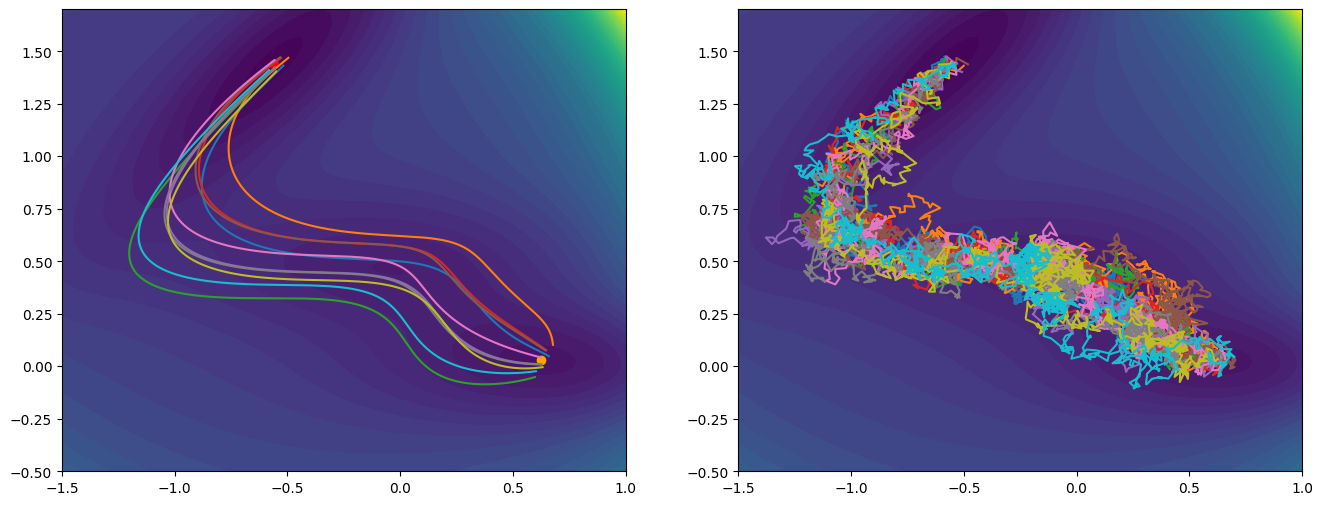

In [18]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
plt.contourf(x, y, z, 50)
plt.plot(x_t_det[:10, :, 0].T, x_t_det[:10, :, 1].T)
plt.scatter(A[0, 0], A[0, 1], color='red')
plt.scatter(B[0, 0], B[0, 1], color='orange')
plt.subplot(122)
plt.contourf(x, y, z, 50)
plt.plot(x_t_stoch[:10, :, 0].T, x_t_stoch[:10, :, 1].T)
plt.scatter(A[0, 0], A[0, 1], color='red')
plt.scatter(B[0, 0], B[0, 1], color='orange')
plt.show()

In [19]:
t = T * jnp.linspace(0, 1, BS).reshape((-1, 1))
key, path_key = jax.random.split(key)
eps = jax.random.normal(path_key, [BS, ndim, 1])

for i in range(200):
    fig, axs = plt.subplots(1,2,figsize=(15, 6))
    axs[0].contourf(x, y, z, 50)
    axs[0].plot(x_t_det[:10, :5*i, 0].T, x_t_det[:10, :5*i, 1].T)
    axs[0].scatter(A[0, 0], A[0, 1], color='red')
    axs[0].scatter(B[0, 0], B[0, 1], color='orange')
    axs[0].set_xlim(x.min(),x.max())
    axs[0].set_ylim(y.min(),y.max())
    axs[0].set_xticks([], [])
    axs[0].set_yticks([], [])

    # ax = plt.subplot(122)
    axs[1].contourf(x, y, z, 50)
    axs[1].plot(x_t_stoch[:10, :5*i, 0].T, x_t_stoch[:10, :5*i, 1].T)
    axs[1].scatter(A[0, 0], A[0, 1], color='red')
    axs[1].scatter(B[0, 0], B[0, 1], color='orange')
    axs[1].set_xlim(x.min(),x.max())
    axs[1].set_ylim(y.min(),y.max())
    axs[1].set_xticks([], [])
    axs[1].set_yticks([], [])
    fig.tight_layout()
    fig.savefig(f'./gifs/simulation/{i:03d}.png', bbox_inches='tight')
    fig.clf()
    plt.close()